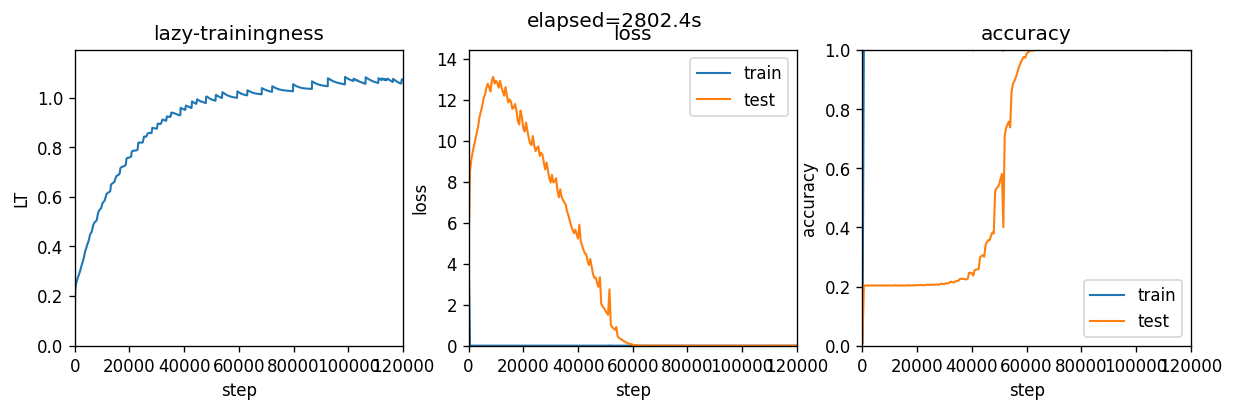

In [11]:
import math
import time
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from IPython.display import display, update_display
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p = 97
train_fraction = 0.2
embed_dim = 128
nhead = 4
nlayers = 2
lr = 1e-3
weight_decay = 5e-2
batch_size = 1024
max_steps = 120000
plot_every = 50
eval_every = 500

pairs = torch.tensor(list(itertools.product(range(p), range(p))), dtype=torch.long)
targets = (pairs[:, 0] + pairs[:, 1]) % p
n_total = pairs.size(0)
perm = torch.randperm(n_total)
n_train = int(train_fraction * n_total)
train_idx = perm[:n_train]
test_idx = perm[n_train:]
X_train = pairs[train_idx]
y_train = targets[train_idx]
X_test = pairs[test_idx]
y_test = targets[test_idx]

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4096, shuffle=False)

class TinyTransformer(nn.Module):
    def __init__(self, vocab, d_model, nhead, nlayers, num_classes, seq_len=2):
        super().__init__()
        self.token = nn.Embedding(vocab, d_model)
        self.pos = nn.Parameter(torch.randn(seq_len, d_model) * 0.01)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4 * d_model, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, nlayers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.token(x) + self.pos.unsqueeze(0)
        x = self.encoder(x)
        x = self.norm(x).mean(dim=1)
        return self.head(x)

def flatten_params(parameters):
    return torch.cat([p.detach().reshape(-1) for p in parameters])

def evaluate(model, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb).item()
            loss_sum += loss * xb.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += xb.size(0)
    model.train()
    return loss_sum / total, correct / total

model = TinyTransformer(p, embed_dim, nhead, nlayers, p).to(device)
opt = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

theta0 = flatten_params(model.parameters()).to(device)
theta0_norm = torch.norm(theta0).item() + 1e-12

steps_hist, lt_hist = [], []
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

plt.ioff()
fig, axs = plt.subplots(1, 3, figsize=(12.0, 3.2))
ax_lt, ax_loss, ax_acc = axs
(line_lt,) = ax_lt.plot([], [], lw=1.25)
(line_loss_tr,) = ax_loss.plot([], [], lw=1.25, label="train")
(line_loss_te,) = ax_loss.plot([], [], lw=1.25, label="test")
(line_acc_tr,) = ax_acc.plot([], [], lw=1.25, label="train")
(line_acc_te,) = ax_acc.plot([], [], lw=1.25, label="test")
ax_lt.set_xlabel("step")
ax_lt.set_ylabel("LT")
ax_lt.set_title("lazy-trainingness")
ax_loss.set_xlabel("step")
ax_loss.set_ylabel("loss")
ax_loss.legend(loc="best")
ax_loss.set_title("loss")
ax_acc.set_xlabel("step")
ax_acc.set_ylabel("accuracy")
ax_acc.set_ylim(0.0, 1.0)
ax_acc.legend(loc="lower right")
ax_acc.set_title("accuracy")
disp = display(fig, display_id=True)

t0 = time.time()
it = iter(train_loader)

for step in range(1, max_steps + 1):
    try:
        xb, yb = next(it)
    except StopIteration:
        it = iter(train_loader)
        xb, yb = next(it)
    xb = xb.to(device)
    yb = yb.to(device)

    logits = model(xb)
    loss = criterion(logits, yb)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    with torch.no_grad():
        theta = flatten_params(model.parameters()).to(device)
        lt = torch.norm(theta - theta0).item() / theta0_norm
        steps_hist.append(step)
        lt_hist.append(lt)

    if step % eval_every == 0 or step == 1:
        tr_loss, tr_acc = evaluate(model, train_loader, criterion)
        te_loss, te_acc = evaluate(model, test_loader, criterion)
        train_loss_hist.append(tr_loss)
        test_loss_hist.append(te_loss)
        train_acc_hist.append(tr_acc)
        test_acc_hist.append(te_acc)

    if step % plot_every == 0 or step == 1:
        line_lt.set_data(steps_hist, lt_hist)
        ax_lt.set_xlim(0, max(step, 10))
        ax_lt.set_ylim(0.0, max(0.02, max(lt_hist) * 1.1))

        eval_x = [i for i in steps_hist if i % eval_every == 0 or i == 1]
        line_loss_tr.set_data(eval_x[: len(train_loss_hist)], train_loss_hist)
        line_loss_te.set_data(eval_x[: len(test_loss_hist)], test_loss_hist)
        ax_loss.set_xlim(0, max(step, 10))
        if train_loss_hist:
            ymax_loss = max(train_loss_hist + test_loss_hist)
            ax_loss.set_ylim(0.0, max(1e-3, ymax_loss) * 1.1)

        line_acc_tr.set_data(eval_x[: len(train_acc_hist)], train_acc_hist)
        line_acc_te.set_data(eval_x[: len(test_acc_hist)], test_acc_hist)
        ax_acc.set_xlim(0, max(step, 10))

        fig.suptitle(f"elapsed={time.time()-t0:.1f}s")
        fig.canvas.draw()
        update_display(fig, display_id=disp.display_id)

plt.close(fig)
